# Initial model experiments

Imports and constants

In [9]:
import os
import pickle
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage import io
import cv2

import tensorflow as tf
from tensorflow.keras import Model, layers

In [10]:
# paths
DATA_IMAGES_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'interim')
PROCESSED_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', 'data_11_classes.npy')
PROCESSED_LABELS_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', 'labels_11_classes.npy')

# image properties
RANDOM_SEED = 7
IMG_WIDTH = 150
IMG_HEIGHT = 150
NUM_CHANNELS = 1

# training parameters
LEARNING_RATE = 0.001
DECAY = 1E-6
BATCH_SIZE = 30
EPOCHS = 10

Let's parse all the filepaths and store them in a list

In [11]:
img_path_list = [os.path.join(DATA_IMAGES_PATH, name) for name in os.listdir(DATA_IMAGES_PATH)]

E:\Projekty\Github-repositories\painting-style-classification\data\interim\9191_Cubism.jpg


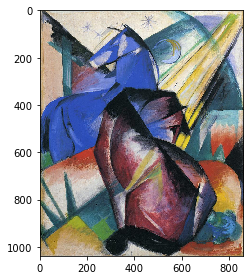

In [12]:
print(img_path_list[-900])
io.imshow(img_path_list[-900])

The following function will read in our images, resize them to desirable format and prepare labels for each of the images.

In [13]:
def prepare_img_data(path_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
    X = []
    y = []
    for value in path_list:
        try:
            X.append(np.array(cv2.resize((cv2.imread(value, cv2.IMREAD_GRAYSCALE)), 
                                         (img_width, img_height))))
            y.append(str.split(value, os.path.sep)[-1]
                     .split('_')[1]
                     .upper()
                     .replace('.JPG', ''))
        except Exception as e:
            print(f"Corrupted image: {value}, skipping the image")
    return X, y

In [14]:
data, labels = prepare_img_data(img_path_list)

Corrupted image: E:\Projekty\Github-repositories\painting-style-classification\data\interim\10769_Ukiyo-e.jpg, skipping the image
Corrupted image: E:\Projekty\Github-repositories\painting-style-classification\data\interim\10873_Ukiyo-e.jpg, skipping the image


Looks like some of the images were corrupted and we couldn't resize them. For now we'll leave it as-is, since we're experimenting with data size and number of distinct classes anyways.

Now, let's see what the image looks like

ROMANTICISM


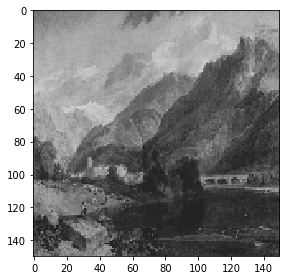

In [15]:
print(labels[-8505])
io.imshow(data[-8505])

Since we'll focus on building a proper pipeline later on, we can save the data as numpy arrays (and load it when necessary).

In [16]:
np.save(PROCESSED_DATA_PATH, data)
np.save(PROCESSED_LABELS_PATH, labels)

# data = np.load(PROCESSED_DATA_PATH)
# labels = np.load(PROCESSED_LABELS_PATH)

For argument's sake, let's see what's the distribution of our data (we know there should be an equal number of all the instances within a class). 

In [29]:
unique, count = np.unique(labels, return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = \n{occurences}")

The number of occurences of each class in the dataset = 
{'ABSTRACT EXPRESSIONISM': 1000, 'ART NOUVEAU (MODERN)': 1000, 'BAROQUE': 1000, 'CUBISM': 1000, 'EARLY RENAISSANCE': 1000, 'EXPRESSIONISM': 1000, 'HIGH RENAISSANCE': 1000, 'IMPRESSIONISM': 1000, 'MANNERISM (LATE RENAISSANCE)': 999, 'NEOCLASSICISM': 1000, 'NORTHERN RENAISSANCE': 1000, 'POST-IMPRESSIONISM': 1000, 'REALISM': 1000, 'ROCOCO': 1000, 'ROMANTICISM': 1000, 'SURREALISM': 1000, 'SYMBOLISM': 1000, 'UKIYO-E': 998}


Let's visualize some of the data we just processed.

In [46]:
def shuffle_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = shuffle_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(3, 3, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(0, len(label_data))
            image = images[index]
            label = labels[index]
            axis.imshow(image, cmap='Greys')
            axis.set_title(f"Class: {label}")
            axis.set_axis_off()

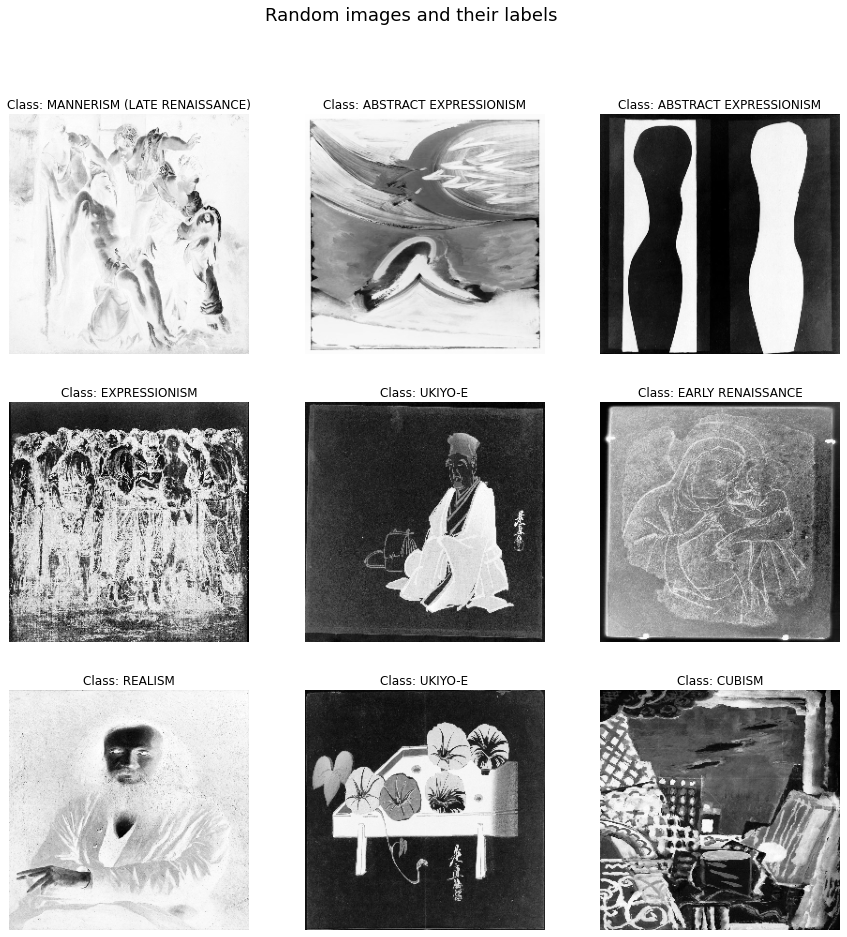

In [47]:
display_rand_imgs(data, labels, RANDOM_SEED)

Lastly, we have to shuffle our data, reshape it to appropriate format for our input layer to handle it, transform labels and create train and test splits.

In [34]:
X, y = shuffle_data(data, labels, RANDOM_SEED)

In [35]:
y[:10]

array(['CUBISM', 'SURREALISM', 'SURREALISM', 'IMPRESSIONISM', 'CUBISM',
       'ABSTRACT EXPRESSIONISM', 'SYMBOLISM', 'HIGH RENAISSANCE',
       'ART NOUVEAU (MODERN)', 'EXPRESSIONISM'], dtype='<U28')

In [36]:
X = X.reshape(-1, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS).astype('float32')
X = X / 255.

In [37]:
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, 17)

print(f"Label value for 1st(0th) element before one-hot encoding \n {np.argmax(y[0])} \nand after one-hot encoding \n {y[0]}")

Label value for 1st(0th) element before one-hot encoding 
 3 
and after one-hot encoding 
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


We'll also set the `NUM_CLASSES` constant to a parameter calculated above 

In [38]:
NUM_CLASSES = y.shape[1]

And split the data

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3400, 128, 128, 3), (850, 128, 128, 3), (3400, 17), (850, 17))

Time to build our model. Since we'll be changing the way our project works and is structured completely within the next few commits, it doesn't really matter how we choose to build it during this experiment. 

We can use either Keras' Sequential API, Functional API, or as is the case here, by creating a class subclassing keras.tf.Model. At this stage, there are no obvious benefits other than more flexibility.

In [40]:
class ConvNet(Model):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        self.conv2 = layers.Conv2D(64, kernel_size=5, activation=tf.nn.relu)
        self.maxpool2 = layers.MaxPool2D(2, strides=2)
        
        self.conv3 = layers.Conv2D(64, kernel_size=5, activation=tf.nn.relu)
        self.maxpool3 = layers.MaxPool2D(2, strides=2)

        self.flatten = layers.Flatten()

        self.fc1 = layers.Dense(32)
        self.dropout = layers.Dropout(rate=0.5)

        self.fc2 = layers.Dense(32)
        self.dropout = layers.Dropout(rate=0.5)

        self.out = layers.Dense(NUM_CLASSES, activation='softmax')

    def call(self, x):
        x = tf.reshape(x, [-1, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

model = ConvNet()

Let's choose optimizers, the loss that will be calculated each step and finally, compile the model

In [41]:
opt_func = tf.keras.optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt_func,
              metrics=['accuracy'])

Let's train the model above

In [42]:
hist = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Train on 2720 samples, validate on 680 samples
Epoch 1/10
2720/2720 [==============================] - 202s 74ms/sample - loss: 3.0928 - accuracy: 0.0496 - val_loss: 2.8333 - val_accuracy: 0.0632
Epoch 2/10
2720/2720 [==============================] - 192s 71ms/sample - loss: 2.8298 - accuracy: 0.0702 - val_loss: 2.8301 - val_accuracy: 0.0647
Epoch 3/10
2720/2720 [==============================] - 185s 68ms/sample - loss: 2.8142 - accuracy: 0.0776 - val_loss: 2.8260 - val_accuracy: 0.0721
Epoch 4/10
2720/2720 [==============================] - 187s 69ms/sample - loss: 2.7937 - accuracy: 0.0912 - val_loss: 2.8205 - val_accuracy: 0.0809
Epoch 5/10
2720/2720 [==============================] - 179s 66ms/sample - loss: 2.7339 - accuracy: 0.1210 - val_loss: 2.8365 - val_accuracy: 0.0838
Epoch 6/10
2720/2720 [==============================] - 187s 69ms/sample - loss: 2.6735 - accuracy: 0.1349 - val_loss: 2.8689 - val_accuracy: 0.0809
Epoch 7/10
2720/2720 [==============================] - 184

Let's see what our model looks like and the number of it's parameters

In [43]:
print(model.summary())

Model: "conv_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  4864      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  6889536   
_________________________________________________________________
dense_4 (Dense)              multiple                  4

Let's visualise the model's performance

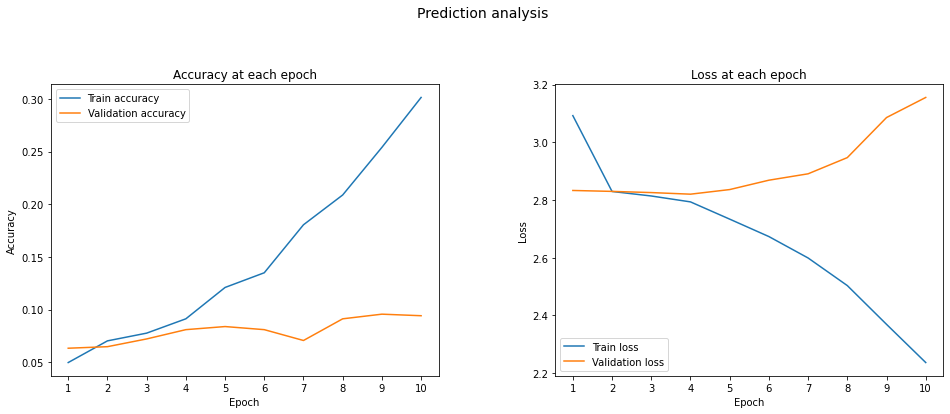

In [46]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
title = figure.suptitle('Prediction analysis', fontsize=14)
figure.subplots_adjust(top=0.8, wspace=0.3)

epoch_list = list(range(1, EPOCHS+1))
# ax1.axhline(y=0.8, color="0.85")
ax1.plot(epoch_list, hist.history['accuracy'], label='Train accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation accuracy')
ax1.set_xticks(np.arange(1, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy at each epoch')
l1 = ax1.legend(loc="best")

# ax2.axhline(y=0.1, color="0.85")
ax2.plot(epoch_list, hist.history['loss'], label='Train loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(1, EPOCHS+1, 1))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss at each epoch')
l2 = ax2.legend(loc="best")

Let's check the model's performance on a never seen before test set

In [47]:
val_loss, val_acc = model.evaluate(x_test, y_test)
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test set loss: {score[0]}')
print(f'Test set accuracy: {score[1]}')

850/850 [==============================] - 14s 16ms/sample - loss: 3.2338 - accuracy: 0.0988
Test set loss: 3.2337912099501667
Test set accuracy: 0.09882353246212006


Plotting a confusion matrix should help us understand where the model struggled and where it performed well

Text(0.5, 60.0, 'Predicted labels')

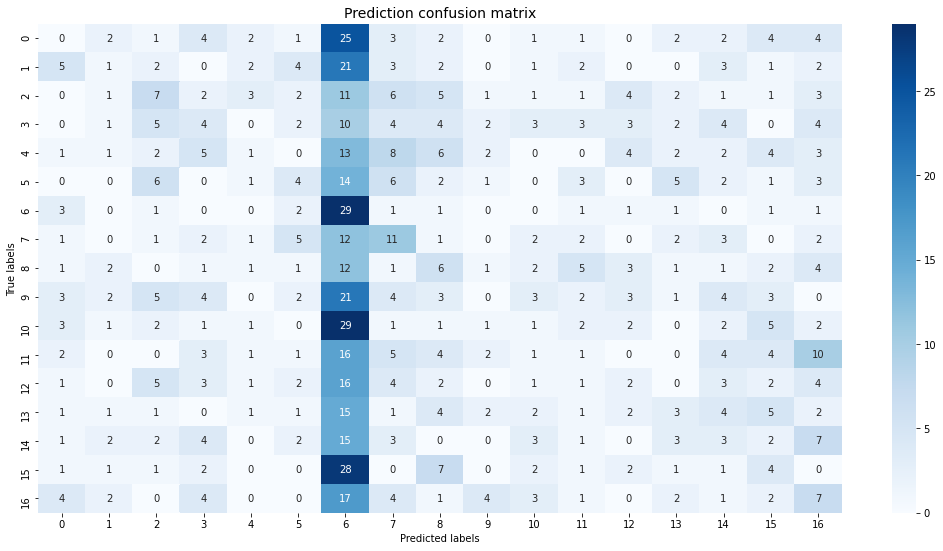

In [48]:
prediction = model.predict(x_test)
predicted_labels = np.argmax(prediction, axis=1)
test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(18, 9))
ax = sns.heatmap(cm,annot=True, cmap='Blues')

plt.title("Prediction confusion matrix", fontsize=14)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [55]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.03      0.02      0.02        54
           1       0.27      0.20      0.23        49
           2       0.13      0.08      0.10        51
           3       0.16      0.16      0.16        51
           4       0.11      0.07      0.09        54
           5       0.26      0.15      0.19        48
           6       0.11      0.60      0.19        42
           7       0.22      0.33      0.27        45
           8       0.13      0.11      0.12        44
           9       0.13      0.05      0.07        60
          10       0.13      0.06      0.08        54
          11       0.10      0.11      0.10        54
          12       0.15      0.15      0.15        47
          13       0.07      0.04      0.05        46
          14       0.14      0.08      0.11        48
          15       0.05      0.02      0.03        51
          16       0.12      0.17      0.14        52

    accuracy              

In [56]:
correct = []
incorrect = []

for i in range(len(y_test)):
    if(predicted_labels[i] == test_labels[i]):
        correct.append(i)
    elif(predicted_labels[i] != test_labels[i]):
        incorrect.append(i)
        
print(f"Our model predicted {len(correct)} out of {len(y_test)} images correctly, while {len(incorrect)} predictions were incorrect")

Our model predicted 114 out of 850 images correctly, while 736 predictions were incorrect


In [ ]:
def plot_predictions(pred_list, pred_string):
    fig, axes = plt.subplots(2, 5, figsize = (16,8))
    plt.suptitle(f"{pred_string} predictions", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(RANDOM_SEED)
            axis.imshow(x_test[pred_list[index]].reshape(64,64), cmap='binary')
            axis.set_title(f"Predicted Label : {predicted_labels[pred_list[index]]} \n Actual Label : {test_labels[pred_list[index]]}")
            axis.set_axis_off()

In [ ]:
plot_predictions(correct, "Correct")

In [ ]:
plot_predictions(incorrect, "Incorrect")